<a href="https://colab.research.google.com/github/Shak97/iceest2019/blob/master/unet_singlechannel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Dependencies

In [0]:
import os
import cv2
import numpy as np
import keras
from keras import backend as k
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from google.colab.patches import cv2_imshow

Using TensorFlow backend.


###Directory Path

In [0]:
#directory path of images and their masks
image_dir = '/content/drive/My Drive/h_segmentation/train_image/images/'
mask_dir = '/content/drive/My Drive/h_segmentation/train_mask/labels/'

###Reading Dir
Reading and sorting of file names from directory

In [0]:
def sort_list(fil):
  fil.sort()
  templist = []
  sublist = []
  m = 0
  start = 0

  for i in range(len(fil)):
    if fil[start][3:6] == fil[i][3:6]:
        templist.append(fil[i])
    else:
        sublist.append('')
        sublist[m] = templist.copy()
        m+=1
        templist.clear()
        templist.append(fil[i])
        start = i
  sublist.append('')
  sublist[m] = templist.copy()

  for eachlist in sublist:
    for i in range(len(eachlist)):
      eachlist[i] = eachlist[i].split('.')[0]

  for ls in sublist:
    for i in range(len(ls)):
      min = int(ls[i][11:])
      minindex = i
      for j in range(i+1, len(ls)):
        if min > int(ls[j][11:]):
          min = int(ls[j][11:])
          minindex = j
      temp = ls[i]
      ls[i] = ls[minindex]
      ls[minindex] = temp

  for x in sublist:
    for y in range(len(x)):
      x[y] = x[y] + '.png'
      
  return sublist

In [0]:
fil = os.listdir(image_dir)
trainx = sort_list(fil)
n = []
def flattenlist(l): 
  for i in l: 
    if type(i) == list: 
      flattenlist(i) 
    else: 
      n.append(i)
flattenlist(trainx)
print(n)

##Reading Train Set
Reading and Preprocessing of training images and their masks.<br />
The dataset used for the task is an MR Heart Segmentation dataset downloaded from medical segmentation decathon website, It consists from 20 subjects scans, which is split in to 14,2 and 4 subjects for train, validation and test set respectively. For more info, visit the following url <br /> https://decathlon-10.grand-challenge.org/home

In [0]:
train = []
for image in range(1578):
  train.append(cv2.imread(image_dir+n[image], cv2.IMREAD_GRAYSCALE))
  
train_X = np.asarray(train)
train_X = train_X.astype('float32')
train_X = train_X.reshape(1578,320,320,1)

for i in range(1578):
  train_X[i,:,:,:] /= 255.0

In [0]:
trainy = []
for image in range(1578):
  trainy.append(cv2.imread(mask_dir+n[image], cv2.IMREAD_GRAYSCALE))
  
train_Y = np.asarray(trainy)
train_Y = train_Y.astype('float32')
train_Y = train_Y.reshape(1578,320,320,1)

for i in range(1578):
  train_Y[i,:,:,:] /= 255.0

##Reading Validation Set
Reading and Preprocessing of Validation images and their masks

In [0]:
val = []
for image in range(1578,1796):
  val.append(cv2.imread(image_dir+n[image], cv2.IMREAD_GRAYSCALE))
  
val_X = np.asarray(val_x)
val_X = val_X.astype('float32')
val_X = val_X.reshape(218,320,320,1)

for i in range(218):
  val_X[i,:,:,:] /= 255.0

In [0]:
valy = []
for image in range(1578,1796):
  valy.append(cv2.imread(mask_dir+n[image], cv2.IMREAD_GRAYSCALE))
  
val_Y = np.asarray(valy)
val_Y = val_Y.astype('float32')
val_Y = val_Y.reshape(218,320,320,1)

for i in range(218):
  val_Y[i,:,:,:] /= 255.0

###Reading Test Set Images and Masks
Reading and Preprocessing of Test images and their masks

In [0]:
testx = []
for image in range(1796,2251):
  testx.append(cv2.imread(image_dir+n[image], cv2.IMREAD_GRAYSCALE))
  
test_X = np.asarray(testx)
test_X = test_X.astype('float32')
test_X = test_X.reshape(455,320,320,1)

for i in range(455):
  test_X[i,:,:,:] /= 255.0

In [0]:
testy = []
for image in range(1796,2251):
  testy.append(cv2.imread(mask_dir+n[image], cv2.IMREAD_GRAYSCALE))
  
test_Y = np.asarray(testy)
test_Y = test_Y.astype('float32')

for i in range(455):
  test_Y[i,:,:] /= 255.0

In [0]:
#converts into binary representation using onehot encoding
train_y = keras.utils.np_utils.to_categorical(y=train_Y)
val_y = keras.utils.np_utils.to_categorical(y=val_Y)

##Dice Score Metric

In [0]:
  def iou_coef(y_true, y_pred, smooth = 1):
    y_true = k.flatten(y_true)
    y_pred = k.flatten(y_pred)
    intersection = k.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (k.sum(y_true) + k.sum(y_pred) + smooth)

###Model Definition and Compilation
The proposed architecture is unet.<br />
Model contains a total of 18 convolutional layers and one final conv layer with 2 output filters.<br />
BatchNormalization is used after every convolutional layer except final.<br />
The activation function is ReLu except the final layer which has a sigmoid function<br />
MaxPool with pool size (2,2) is applied after every two convolution layers in the Encoder part of the model except the final layer. <br />
Keras's Conv2DTranspose is applied in the decoder for UpSampling.<br />
Input Shape (320,320,1); Output Shape (320,320,2) <br />
The Optimizer is Adam with categorical crossentropy loss function.
Dice Score Metric is used for model evaluation.



In [0]:
def unet(weights = None, input_size = (320,320,1)):
  
  inp = keras.engine.input_layer.Input(input_size)
  #Encoder
  c1 = Conv2D(64, (3,3), activation='relu', padding='same')(inp)
  c1 = BatchNormalization()(c1)
  c1 = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(c1)
  c1 = BatchNormalization()(c1)
  p1 = MaxPooling2D(pool_size=(2,2))(c1)
  
  c2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(p1)
  c2 = BatchNormalization()(c2)
  c2 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(c2)
  c2 = BatchNormalization()(c2)
  p2 = MaxPooling2D(pool_size=(2,2))(c2)
  p2 = Dropout(0.3)(p2)
  
  c3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(p2)
  c3 = BatchNormalization()(c3)
  c3 = Conv2D(256, (3,3), activation = 'relu', padding = 'same')(c3)
  c3 = BatchNormalization()(c3)
  p3 = MaxPooling2D(pool_size=(2,2))(c3)
  
  c4 = Conv2D(512, (3,3), activation = 'relu', padding='same')(p3)
  c4 = BatchNormalization()(c4)
  c4 = Conv2D(512, (3,3), activation = 'relu', padding = 'same')(c4)
  c4 = BatchNormalization()(c4)
  p4 = MaxPooling2D(pool_size=(2,2))(c4)
  
  c5 = Conv2D(1024, (3,3), activation = 'relu', padding='same')(p4)
  c5 = BatchNormalization()(c5)
  c5 = Conv2D(1024, (3,3), activation = 'relu', padding = 'same')(c5)
  c5 = BatchNormalization()(c5)
  
  #Decoder
  u6 = Conv2DTranspose(512, (3,3), activation = 'relu', strides = (2,2), padding = 'same')(c5)
  concat6 = concatenate([u6,c4])
  c6 = Conv2D(512, (3,3), activation = 'relu', padding = 'same')(concat6)
  c6 = BatchNormalization()(c6)
  c6 = Conv2D(512, (3,3), activation = 'relu', padding = 'same')(c6)
  c6 = BatchNormalization()(c6)
  
  u7 = Conv2DTranspose(256, (3,3), activation = 'relu', strides = (2,2), padding = 'same')(c6)
  concat7 = concatenate([u7,c3])
  c7 = Conv2D(256, (3,3), activation = 'relu', padding = 'same')(concat7)
  c7 = BatchNormalization()(c7)
  c7 = Conv2D(256, (3,3), activation = 'relu', padding = 'same')(c7)
  c7 = BatchNormalization()(c7)
  
  u8 = Conv2DTranspose(128, (3,3), activation = 'relu', strides = (2,2), padding = 'same')(c7)
  concat8 = concatenate([u8,c2])
  c8 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(concat8)
  c8 = BatchNormalization()(c8)
  c8 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(c8)
  c8 = BatchNormalization()(c8)
  C8 = Dropout(0.3)(c8)
  
  u9 = Conv2DTranspose(64, (3,3), activation = 'relu', strides = (2,2), padding = 'same')(c8)
  concat9 = concatenate([u9,c1])
  c9 = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(concat9)
  c9 = BatchNormalization()(c9)
  c9 = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(c9)
  c9 = BatchNormalization()(c9)
  
  c10 = Conv2D(2, (1,1), activation = 'sigmoid')(c9)
  
  model = Model(input=inp, output=c10)
  model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = [iou_coef] )
  
  if(weights):
    model.load_weights(weights)
    
  return model
  
  

In [0]:
model = unet()

##Model Traning

In [0]:
model_fit = model.fit(x=train_X,y=train_y, validation_data=(val_X,val_y), batch_size = 1, epochs=10)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1578 samples, validate on 218 samples
Epoch 1/10
1578/1578 [==============================] - 677s 429ms/step - loss: 0.0017 - iou_coef: 0.9617 - val_loss: 0.0028 - val_iou_coef: 0.9594
Epoch 2/10
1578/1578 [==============================] - 665s 421ms/step - loss: 0.0014 - iou_coef: 0.9615 - val_loss: 0.0057 - val_iou_coef: 0.9514
Epoch 3/10
1578/1578 [==============================] - 665s 421ms/step - loss: 0.0014 - iou_coef: 0.9613 - val_loss: 0.0028 - val_iou_coef: 0.9625
Epoch 4/10
1578/1578 [==============================] - 664s 421ms/step - loss: 0.0013 - iou_coef: 0.9626 - val_loss: 0.0030 - val_iou_coef: 0.9675
Epoch 5/10
1578/1578 [==============================] - 664s 421ms/step - loss: 0.0011 - iou_coef: 0.9655 - val_loss: 0.0034 - val_iou_coef: 0.9695
Epoch 6/10
1578/1578 [==============================] - 664s 421ms/step - loss: 0.0011 - iou_coef: 0.9685 - val_loss: 0

##Plotting Training Curves

Text(0.5, 1.0, 'Training Set')

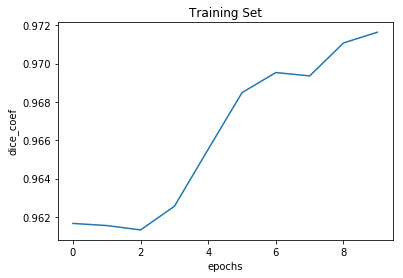

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(model_fit.history['iou_coef'])
plt.xlabel('epochs')
plt.ylabel('dice_coef')
plt.title('Training Set')

Text(0.5, 1.0, 'Validation Set')

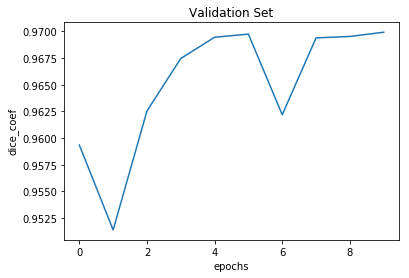

In [0]:
plt.plot(model_fit.history['val_iou_coef'])
plt.xlabel('epochs')
plt.ylabel('dice_coef')
plt.title('Validation Set')

Text(0.5, 1.0, 'Training Set')

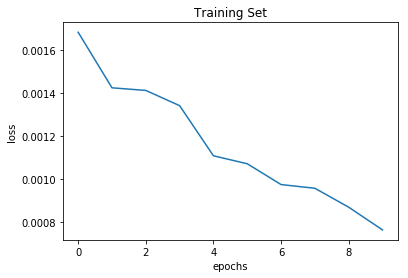

In [0]:
plt.plot(model_fit.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training Set')

Text(0.5, 1.0, 'Validation Set')

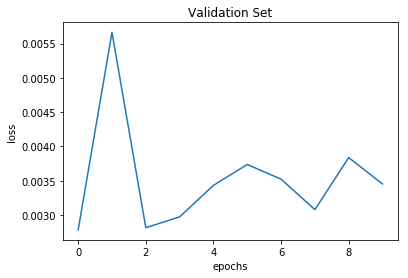

In [0]:
plt.plot(model_fit.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Validation Set')

##Making Predictions on Test Data

In [0]:
pred = model.predict(test_X, batch_size=1, verbose=1)

455/455 [==============================] - 66s 145ms/step


In [0]:
print(pred.shape)
#converting shape to back to single channel
pred_new = np.argmax(pred, axis=3, out=None)

(455, 320, 320, 2)

In [0]:
print(pred_new.shape)
pred_new = pred_new.astype('float32')


(455, 320, 320)

##Calculating Dice Scores of Test Examples

In [0]:
temp = []
for i in range(455):
  temp.append(k.eval(iou_coef(((test_Y[i,:,:])),(pred_new[i,:,:]))))


In [0]:
t = np.asarray(temp)
dice = np.zeros(len(temp))
for i in range(455):
  if (t[i] > 0.5):
    dice[i] = 1
  else:
    dice[i] = 0

In [0]:
np.sum(dice)/455

0.8879120879120879

In [0]:
print('Average Dice Score: ' + str(np.sum(dice)/455))

Average Dice Score: 0.8879120879120879


In [0]:
print('Variance: ' + str(np.var(dice)))

Variance: 0.0995242120516846


##Test Statistics

In [0]:
def tp(y_pred, y_true):
  y_pred = k.eval(k.flatten(y_pred))
  y_true = k.eval(k.flatten(y_true))
  return (k.sum(y_pred*y_true))

def fn(y_pred, y_true):
  y_pred = (k.flatten(y_pred))
  y_true = (k.flatten(y_true))
  op0 = k.sum(y_true)
  op1 = k.sum(y_pred*y_true)
  return (op0 - op1)

def tn(y_pred, y_true):
  y_pred = (k.flatten(y_pred))
  y_true = (k.flatten(y_true))
  op1 = (1-y_pred)
  op2 = (1-y_true)
  return (k.sum(op1*op2))

def fp(y_pred, y_true):
  y_pred = (k.flatten(y_pred))
  y_true = (k.flatten(y_true))
  op0 = k.sum(1 - y_true)
  op1 = (1-y_pred)
  op2 = (1- y_true)
  op3 = k.sum(op1*op2)
  return (op0 - op3)

In [0]:
TP = []
for i in range(455):
  TP.append(k.eval(tp(pred_new[i,:,:], test_Y[i,:,:])))

In [0]:
TN = []
for i in range(455):
  TN.append(k.eval(tn(pred_new[i,:,:], test_Y[i,:,:])))

In [0]:
FP = []
for i in range(455):
  FP.append(k.eval(fp(pred_new[i,:,:], test_Y[i,:,:])))

In [0]:
FN = []
for i in range(455):
  FN.append(k.eval(fn(pred_new[i,:,:], test_Y[i,:,:])))

In [0]:
tp = np.asarray(TP)
tn = np.asarray(TN)
fp = np.asarray(FP)
fn = np.asarray(FN)

##Large Segment Example

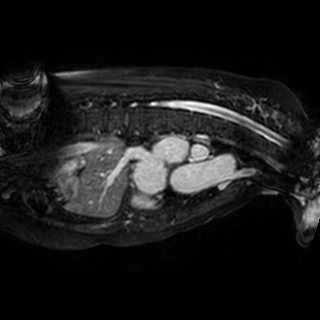

In [0]:
cv2_imshow(test_X[421,:,:] * 255.0)

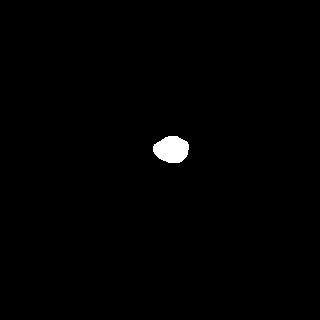

In [0]:
cv2_imshow(pred_new[421,:,:] * 255.0)

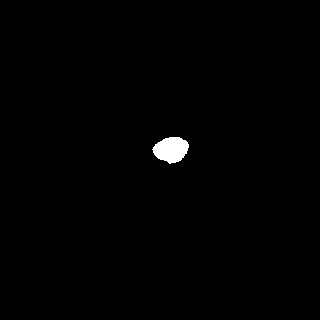

In [0]:
 cv2_imshow(test_Y[421,:,:] * 255.0)

##Small Segment Example

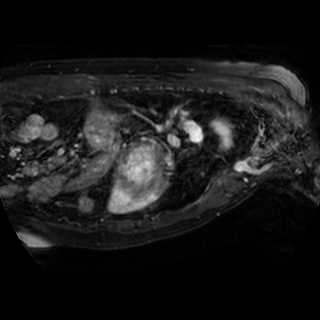

In [0]:
cv2_imshow(test_X[271,:,:] * 255.0)


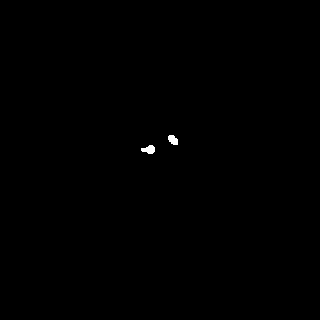

In [0]:
cv2_imshow(test_Y[271,:,:] * 255.0)

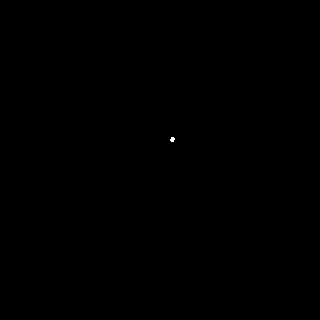

In [0]:
cv2_imshow(pred_new[271,:,:] * 255.0)